<a href="https://colab.research.google.com/github/tArkiopfIre/quantum_simulation_vqe/blob/main/vqe_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit ipywidgets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 91.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 98.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 87.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [2]:
import numpy as np
from qiskit import QuantumCircuit, Aer, execute
from scipy.optimize import minimize
import time

writing hamiltonian (taking J = 1)

In [3]:
J = 1.0
coefficients = [J, J, J]

# Define the Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

# Construct the Heisenberg Hamiltonian
hamiltonian = coefficients[0] * np.kron(sigma_x, np.kron(sigma_x, np.eye(2))) + \
              coefficients[1] * np.kron(sigma_y, np.kron(sigma_y, np.eye(2))) + \
              coefficients[2] * np.kron(sigma_z, np.kron(sigma_z, np.eye(2)))

Function to Initialize the ansatz circuit

In [4]:
def initialize_ansatz(depth, num_qubits, include_two_qubit_gates=True):
    circuit = QuantumCircuit(num_qubits)
    for _ in range(depth):
        for i in range(num_qubits):
            gate_name = np.random.choice(['rx', 'ry', 'rz'])
            angle = np.random.uniform(0, 2 * np.pi)
            getattr(circuit, gate_name)(angle, i)
        if include_two_qubit_gates:
            for i in range(num_qubits - 1):
                circuit.cx(i, i + 1)
    return circuit

Function to calculate the expectation value of the hamiltonian

In [5]:
def expectation_value(circuit):
    backend = Aer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    statevector = job.result().get_statevector()
    expectation = np.real(np.vdot(statevector, np.dot(hamiltonian, statevector)))
    return expectation


Defining the cost function


In [6]:
def cost_function(params, depth, num_qubits, include_two_qubit_gates=True):
    circuit = initialize_ansatz(depth, num_qubits, include_two_qubit_gates)
    param_dict = {k: v for k, v in zip(circuit.parameters, params)}
    circuit = circuit.assign_parameters(param_dict)
    return expectation_value(circuit)

Defining the parameters we will be using (L-BFGS-B will be used as optimization algorithm)

In [7]:
num_qubits = 3
depth = 4
num_params = depth * 3 * num_qubits  # Each gate has 3 parameters
initial_params = np.random.uniform(0, 2 * np.pi, num_params)

With two-qubit gates

In [23]:
start_time = time.time()
result_with_gates = minimize(cost_function, initial_params, args=(depth, num_qubits, True), method='L-BFGS-B')
end_time = time.time()
execution_time_with_gates = end_time - start_time
optimal_params_with_gates = result_with_gates.x
final_energy_with_gates = result_with_gates.fun

print("Optimal Parameters:", optimal_params_with_gates)
print("Final Energy:", final_energy_with_gates)
print("Execution Time:", execution_time_with_gates, "seconds")

Optimal Parameters: [5.44001704 0.59475465 2.82902051 0.10394988 3.55000915 3.68745833
 0.56809165 0.57122756 2.68672367 6.27017269 4.50897381 2.47648081
 0.46820715 1.13163692 2.02627259 4.11818168 0.79583195 3.91145795
 5.73591258 0.37652806 1.56267404 1.57450058 2.56609649 1.05367212
 4.56795092 5.50242579 0.92895498 0.05814907 5.96528805 0.43968387
 1.77807707 3.06417925 5.5317642  1.53945162 5.8929432  0.06799329]
Final Energy: 0.44001488825455015
Execution Time: 5.022561073303223 seconds


Without two-qubit gates

In [24]:
start_time = time.time()
result_without_gates = minimize(cost_function, initial_params, args=(depth, num_qubits, False), method='L-BFGS-B')
end_time = time.time()
execution_time_without_gates = end_time - start_time
optimal_params_without_gates = result_without_gates.x
final_energy_without_gates = result_without_gates.fun

print("Optimal Parameters:", optimal_params_without_gates)
print("Final Energy:", final_energy_without_gates)
print("Execution Time:", execution_time_without_gates, "seconds")

Optimal Parameters: [5.44001738 0.59475434 2.82902056 0.10394958 3.55000892 3.6874583
 0.5680913  0.5712271  2.68672382 6.27017309 4.50897382 2.47648046
 0.46820758 1.1316364  2.02627247 4.11818193 0.79583078 3.91145732
 5.73591273 0.37652836 1.56267422 1.57450071 2.56609686 1.05367206
 4.56795077 5.5024261  0.92895471 0.05814879 5.96528823 0.43968366
 1.77807691 3.06417964 5.5317642  1.53945163 5.89294334 0.0679934 ]
Final Energy: 0.22142415364724202
Execution Time: 5.331765651702881 seconds


Plotting the accuracy and time taken with and without two-qubit gates

In [12]:
import matplotlib.pyplot as plt

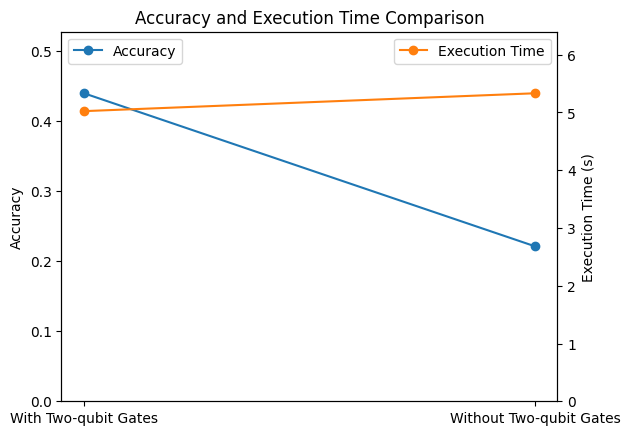

In [25]:
labels = ['With Two-qubit Gates', 'Without Two-qubit Gates']
accuracy = [final_energy_with_gates, final_energy_without_gates]
execution_time = [execution_time_with_gates, execution_time_without_gates]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(labels, accuracy, marker='o', color='tab:blue', label='Accuracy')
ax2.plot(labels, execution_time, marker='o', color='tab:orange', label='Execution Time')

ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Execution Time (s)')

ax1.set_ylim([0, max(accuracy) * 1.2])
ax2.set_ylim([0, max(execution_time) * 1.2])

ax1.set_title('Accuracy and Execution Time Comparison')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()